### Statistics in Table 1 and Table 4

In [ ]:

import os
import numpy as np
import scipy.stats

os.chdir('/results/uniform/')
str_ = 'experiment_results_di_large_uniform_.npy'
results = np.load(str_, allow_pickle=True).item()

algo_names        = list(results.keys())
longest_dict      = max(results.values(), key=lambda d: len(d))
time_horizon_list = sorted(longest_dict.keys())

baseline = 'BASA'
alpha = 0.05 

valid_opt_Ts = [T for T, entries in results.get('optimal', {}).items() if entries]
if not valid_opt_Ts:
    raise ValueError("`results['optimal']` empty！")
max_opt_T = max(valid_opt_Ts)


for algo in algo_names:
    print(f'=== {algo} ===')
    for T in time_horizon_list:
        if T > 300000:
            continue
        entries = results[algo].get(T, [])
        if algo == 'random':
            vals = np.array([e[0] for e in entries])
        elif algo == 'BASA':
            vals = np.array(entries, dtype=float)
        else:
            vals = np.array([e[1] for e in entries])

        if vals.size == 0:
            print(f'  T = {T:>3}: no data')
            continue
        mean_a, std_a = vals.mean(), vals.std(ddof=1)

        opt_entries = results.get('optimal', {}).get(T, [])
        if not opt_entries:
            print(f'  T = {T:>3}: optimal at T={max_opt_T}')
            opt_entries = results['optimal'][max_opt_T]

        opt_vals = np.array([e[1] for e in opt_entries])
        mean_opt = opt_vals.mean()  
        

        rel_diff = (mean_a - mean_opt) / mean_opt

        if algo == baseline:
            print(f'  T = {T:>3}: mean={mean_a:.4f} (±{std_a:.4f}), rel_diff_opt={rel_diff:.4f}')
        else:
            base_entries = results[baseline].get(T, [])
            if not base_entries:
                print(f'  T = {T:>3}: baseline no data')
                continue

            if baseline == 'BASA':
                base = np.array(base_entries, dtype=float)
            else:
                base = np.array([e[1] for e in base_entries])

            mean_b, std_b = base.mean(), base.std(ddof=1)

            # Welch’s t-test
            _, p_val = scipy.stats.ttest_ind(vals, base, equal_var=False)
            sig = '↑' if (p_val < alpha and mean_a > mean_b) else '↓' if (p_val < alpha) else '—'

            print(f'  T = {T:>3}: '
                  f'{algo} mean={mean_a:.4f} (±{std_a:.4f}), '
                  f'{baseline} mean={mean_b:.4f} (±{std_b:.4f}), '
                  f'rel_diff_opt={rel_diff:.4f}, {sig}')
    print('-' * 60)


### Convergence Curve (Figure 1)

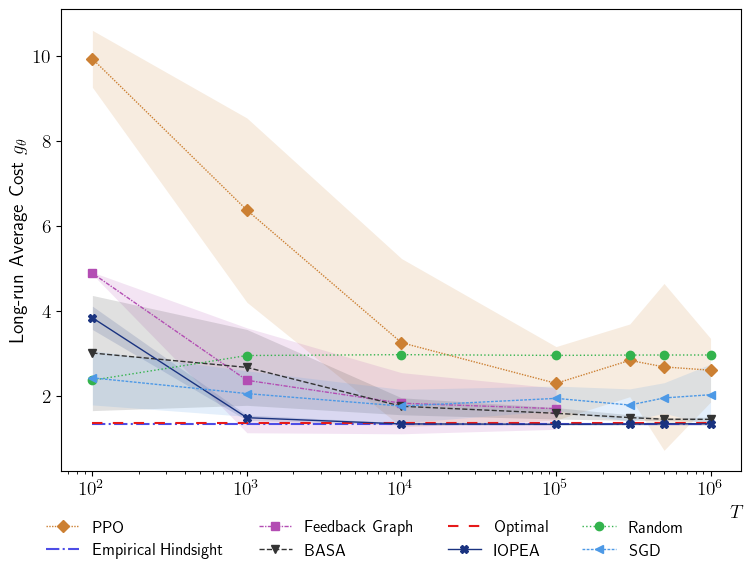

In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

os.chdir('/Users/bin/Desktop/IOPEA/results/normal/')
results = np.load('experiment_results_di_small_normal_.npy', allow_pickle=True).item()

if 'BASA' in results:
    results['heuristic'] = results.pop('BASA')


if 'SGD' in results:
    results['sgd'] = results.pop('SGD')

rows = []
for algo, d in results.items():
    for T, entries in d.items():
        if not entries:
            continue
        if algo == 'random':
            vals = np.array([e[0] for e in entries])
        elif algo == 'heuristic':
            vals = np.array(entries, dtype=float)
        else:
            vals = np.array([e[1] for e in entries])
        rows.append({'algorithm': algo, 'T': T, 'mean': vals.mean(), 'std': vals.std(ddof=1)})

df = pd.DataFrame(rows)
df.sort_values(['algorithm','T'], inplace=True)
all_T = sorted(df['T'].unique())

line_styles = {
    'our_algo':           'solid',
    'optimal':            (0, (5,5)),
    'random':             'dotted',
    'feedback_graph':     (0, (3,1,1,1)),
    'empirical_hindsight':'dashdot',
    'PPO':                (0, (1,1)),
    'heuristic':          'dashed',
    'sgd':                (0, (2,1))   
}

markers = {
    'our_algo':'X','optimal':'P','random':'o',
    'feedback_graph':'s','empirical_hindsight':'^',
    'PPO':'D','heuristic':'v','sgd':'<'  
}

mapping = {
    'our_algo':r'\textsf{IOPEA}','optimal':r'\textsf{Optimal}',
    'random':r'\textsf{Random}','feedback_graph':r'\textsf{Feedback Graph}',
    'empirical_hindsight':r'\textsf{Empirical Hindsight}',
    'PPO':r'\textsf{PPO}','heuristic':r'\textsf{BASA}',
    'sgd':r'\textsf{SGD}'   
}

color_mapping = {
    'our_algo':(0.1,0.2,0.5),'optimal':(0.9,0.1,0.1),
    'random':(0.2,0.7,0.3),'feedback_graph':(0.7,0.3,0.7),
    'empirical_hindsight':(0.3,0.3,0.9),'PPO':(0.8,0.5,0.2),
    'heuristic':(0.2,0.2,0.2),
    'sgd':(0.3,0.6,0.9)  
}


fig, ax = plt.subplots(figsize=(8,6))
ax.set_xscale('log')

for algo in df['algorithm'].unique():
    sub = df[df['algorithm']==algo].sort_values('T')
    c   = color_mapping[algo]
    ls  = line_styles.get(algo,'solid')
    mk  = markers.get(algo,None)
    lbl = mapping.get(algo,algo)

    if algo in ['optimal','empirical_hindsight']:
        min_val = sub['mean'].min()
        ax.hlines(
            min_val, xmin=all_T[0], xmax=all_T[-1],
            colors=c, linestyles=ls, label=lbl, linewidth=1.5
        )
        continue

    ax.plot(
        sub['T'], sub['mean'],
        label=lbl, linestyle=ls, marker=mk,
        markersize=6, color=c, linewidth=1
    )

    
    if algo not in ['random','optimal','empirical_hindsight']:
        ax.fill_between(
            sub['T'],
            sub['mean']-sub['std'],
            sub['mean']+sub['std'],
            color=c, alpha=0.15, linewidth=0
        )


ax.set_xlabel(r"$T$", fontsize=14, loc='right')
ax.set_ylabel(r"Long-run Average Cost ${g_{\theta}}$", fontsize=14)
ax.tick_params(labelsize=14)

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles, labels, ncol=4, fontsize=12, frameon=False,
    loc='lower center', bbox_to_anchor=(0.5,0.01), bbox_transform=fig.transFigure
)
plt.subplots_adjust(bottom=0.18, top=0.95, left=0.12, right=0.97)
plt.show()
fig.savefig(
    'performance_vs_T.pdf', format='pdf', dpi=300,
    bbox_inches='tight', pad_inches=0.02
)